# 防止标签泄漏
在使用膜染色对图像中的细胞进行分割时，一个常见的问题是标签_泄漏_。当使用诸如[种子分水岭]()等算法时，可以通过过滤图像来防止这些泄漏，例如使用局部最大值滤波器。

In [1]:
import napari_segment_blobs_and_things_with_membranes as nsbatwm
from skimage.data import cells3d
import stackview
import pyclesperanto_prototype as cle
import matplotlib.pyplot as plt

为了演示目的，我们使用[scikit-image的cells3d示例图像](https://scikit-image.org/docs/stable/api/skimage.data.html#skimage.data.cells3d)。

In [2]:
image = cells3d()[:,0]
image.shape

(60, 256, 256)

我们在Z-Y平面查看它的一个切片。为了代码简洁，在此图之后我们将省略绘图轴标签。

Text(0, 0.5, 'Z')

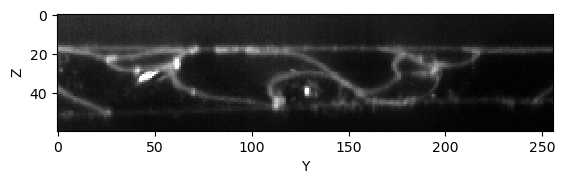

In [3]:
cle.imshow(image[:,:,128], max_display_intensity=20000, continue_drawing=True)
plt.xlabel("Y")
plt.ylabel("Z")

当对这个数据集应用种子分水岭算法（在3D中）时，我们可以看到一些标签在Z方向上泄漏。它们与组织层外部的区域合并。

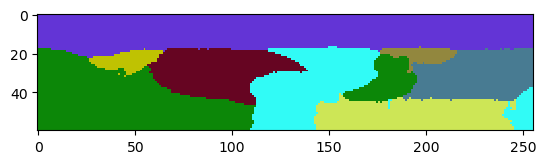

In [4]:
reference_labels = nsbatwm.local_minima_seeded_watershed(image, spot_sigma=9)

cle.imshow(reference_labels[:,:,128], labels=True)

通过对原始图像应用最大值滤波器，可以减少这个问题。它将导致更厚的膜，从而降低分水岭算法通过膜上的孔洞泄漏的机会。

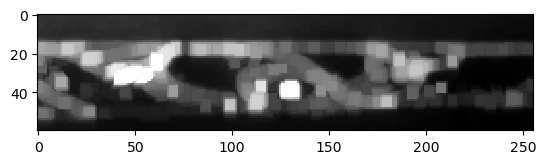

In [5]:
thicker_membranes = nsbatwm.maximum_filter(image, radius=2)

cle.imshow(thicker_membranes[:,:,128], max_display_intensity=20000)

得到的标签图像有较少的泄漏标签，但在所有方向上都失去了标签边界的准确性。

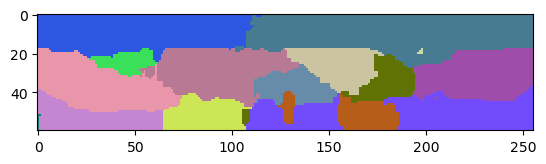

In [6]:
labels1 = nsbatwm.local_minima_seeded_watershed(thicker_membranes, spot_sigma=9)

cle.imshow(labels1[:,:,128], labels=True)

泄漏通常似乎只发生在Z方向，这是常见显微技术的[点扩散函数](https://en.wikipedia.org/wiki/Point_spread_function)效应。它通常是各向异性的，因此，显微镜在Z方向上捕捉膜的能力不如在X和Y方向上。

为了只处理X和Y方向的标签泄漏问题，并保留Z方向的一些准确性，我们需要应用一个可以在X、Y和Z方向上指定不同半径的最大值滤波器。

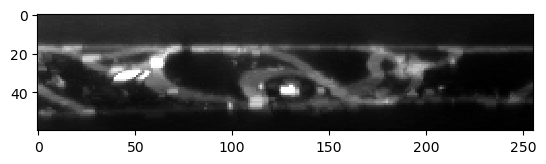

In [7]:
thinker_membranes_in_x_y = cle.maximum_sphere(image, radius_x=2, radius_y=2, radius_z=0)

cle.imshow(thinker_membranes_in_x_y[:,:,128], max_display_intensity=20000)

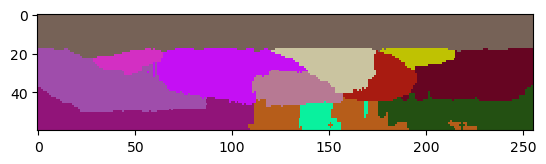

In [8]:
labels2 = nsbatwm.local_minima_seeded_watershed(thinker_membranes_in_x_y, spot_sigma=9)

cle.imshow(labels2[:,:,128], labels=True)

## 在Z方向上排除图像边缘的标签
单层组织的图像通常以一种方式采集，我们可以看到一些像素，后来在组织顶部和底部（在Z方向）分割出的标签。我们可以移除这些标签，同时明确保留那些在X和Y方向接触图像边界的标签。

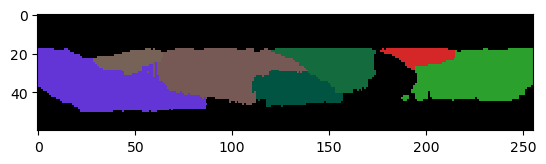

In [9]:
corrected_labels = cle.exclude_labels_on_edges(labels2, 
                                               exclude_in_x=False, 
                                               exclude_in_y=False, 
                                               exclude_in_z=True)

cle.imshow(corrected_labels[:,:,128], labels=True)

显然，我们仍然失去了一个泄漏到组织下方区域的细胞。不过，要获得完美的结果可能是不可能的。